# Import Libraries

In [54]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from pyngrok import ngrok
import threading
import uvicorn

# Data generators

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/intel-image-classification/seg_train/seg_train',
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/intel-image-classification/seg_test/seg_test',
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [16]:
# Classes found by keras
print(train_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


# AlexNet Definition

In [17]:
def alexnet_model(input_shape=(227, 227, 3), num_classes=6):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = layers.Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Compile Model

In [18]:
model = alexnet_model(num_classes=6)

In [27]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping and Learning Rate Scheduler

In [20]:
# Stop training when validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# Create checkpoints for saving the best model
checkpoint = ModelCheckpoint(
    "best_alexnet.h5", 
    monitor='val_accuracy', 
    save_best_only=True
)

# Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2, 
    min_lr=1e-7,
    verbose=1
)

# Train the model

In [21]:
model = models.load_model("best_alexnet.h5")

NOTE: Here, the accuracy seems to be very high even at the first epoch. This is because i had trained the model previosly and added checkpoints. The new training started from the previous checkpoint.

In [28]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 187s 844ms/step - accuracy: 0.8525 - loss: 0.4123 - val_accuracy: 0.7760 - val_loss: 0.6255 - learning_rate: 1.0000e-04
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 184s 835ms/step - accuracy: 0.8639 - loss: 0.3897 - val_accuracy: 0.8020 - val_loss: 0.5558 - learning_rate: 1.0000e-04
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 187s 847ms/step - accuracy: 0.8745 - loss: 0.3472 - val_accuracy: 0.8197 - val_loss: 0.4920 - learning_rate: 1.0000e-04
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 185s 841ms/step - accuracy: 0.8846 - loss: 0.3273 - val_accuracy: 0.7973 - val_loss: 0.5617 - learning_rate: 1.0000e-04
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 186s 845ms/step - accuracy: 0.8835 - loss: 0.3272 - val_accuracy: 0.8473 - val_loss: 0.4305 - learning_rate: 1.0000e-04
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 185s 839ms/step - accuracy: 0.8892 - loss: 0.2991 - val_accuracy: 0.6603 - val_loss: 1.1750 - learning_rate: 1.0000e-04
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 

# Vizualize training accuracy and loss

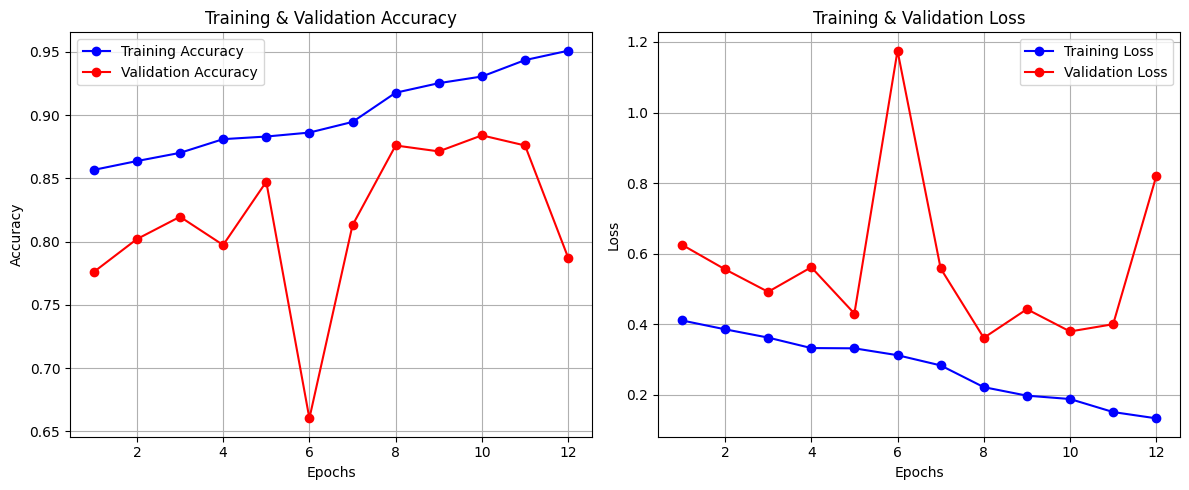

In [29]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# FastAPI

In [30]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [52]:
!pip install fastapi uvicorn pyngrok --quiet

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
ngrok_key = user_secrets.get_secret("ngrok_api_key")

In [6]:
%%writefile main.py
from fastapi import FastAPI, UploadFile, File
from tensorflow.keras import models
from fastapi.responses import JSONResponse
from PIL import Image
from tensorflow.keras.preprocessing import image
import io
import numpy as np

# Load trained AlexNet model
model = models.load_model("best_alexnet.h5")

# Your class names
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

app = FastAPI(
    title="Intel Image Classification API",
    description="Upload an image and get AlexNet-based prediction.",
    version="1.0"
)

@app.get("/")
def read_root():
    return {
        "message": "Welcome to the Intel Image Classification API",
        "docs": "/docs",
        "predict_endpoint": "/predict"
    }

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    # Read uploaded image
    contents = await file.read()
    img = Image.open(io.BytesIO(contents)).convert("RGB")

    # Preprocess
    img = img.resize((227, 227))
    img_arr = image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # Predict
    preds = model.predict(img_arr)
    class_id = np.argmax(preds[0])
    confidence = float(np.max(preds[0]))

    return JSONResponse({
        "predicted_class": classes[class_id],
        "confidence": confidence
    })

Overwriting main.py


In [ ]:
import os

# Kill ALL uvicorn processes
os.system("ps aux | grep uvicorn")
os.system("pkill -9 -f uvicorn")

# Kill any Python processes stuck on port 8000
os.system("fuser -k 8000/tcp")

# Kill ngrok too
from pyngrok import ngrok
ngrok.kill()

print("All processes on port 8000 killed.")

In [3]:
import threading, uvicorn

# If a server thread exists, make sure it stops
try:
    server_thread.running = False
except:
    pass

def run_server():
    server_thread.running = True
    uvicorn.run("main:app", host="0.0.0.0", port=8000, reload=False)

server_thread = threading.Thread(target=run_server)
server_thread.daemon = True
server_thread.start()

print("Uvicorn server started on port 8000")

Uvicorn server started on port 8000


2025-11-18 07:56:02.707916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763452562.734808    1112 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763452562.742912    1112 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from pyngrok import ngrok

ngrok.set_auth_token(ngrok_key)
public_url = ngrok.connect(8000)
print("Public URL:", public_url.public_url)

Public URL: https://noncorporately-transchannel-blondell.ngrok-free.dev


I0000 00:00:1763452566.561737    1112 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763452566.562382    1112 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
INFO:     Started server process [1098]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     2407:1400:aa69:52c0:885a:fb92:9f3a:68ab:0 - "GET / HTTP/1.1" 200 OK
INFO:     2407:1400:aa69:52c0:885a:fb92:9f3a:68ab:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     2407:1400:aa69:52c0:885a:fb92:9f3a:68ab:0 - "GET /openapi.json HTTP/1.1" 200 OK


I0000 00:00:1763452587.347940    1157 service.cc:148] XLA service 0x7b0470004f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763452587.347984    1157 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763452587.347988    1157 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763452587.414606    1157 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
INFO:     2407:1400:aa69:52c0:885a:fb92:9f3a:68ab:0 - "POST /predict HTTP/1.1" 200 OK


I0000 00:00:1763452588.662827    1157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
